In [27]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

path = Path("TTR_mrna.lunp")

# 1) Pre-filter the file into clean rows: keep lines that start with a number
clean_lines = []
with path.open("r", encoding="utf-8", errors="replace") as f:
    for ln in f:
        s = ln.strip()
        if not s or s.startswith("#"):
            continue
        if re.match(r"^\d+", s):          # keep only data lines
            clean_lines.append(s)

if not clean_lines:
    raise ValueError("No data rows found after skipping comments. Is the path correct?")

# 2) Parse as whitespace-separated; treat 'NA' as missing
from io import StringIO
buf = StringIO("\n".join(clean_lines))
df = pd.read_csv(
    buf,
    sep=r"\s+",
    header=None,
    engine="python",
    na_values=["NA"],
    keep_default_na=False
)

# Name columns: col0 = position, the rest are u1..uU
U = df.shape[1] - 1
df.columns = ["pos"] + [f"u{k}" for k in range(1, U + 1)]


# Optional: convert to numeric (already should be), just in case
for c in df.columns[1:]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df=df.fillna(0)

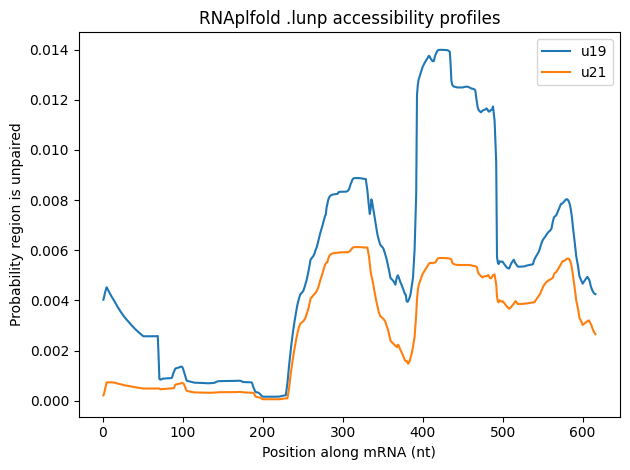

In [28]:
to_show = [19,21]
to_show = [k for k in to_show if k <= U]

plt.figure()
for k in to_show:
    # moving-average smoothing for readability (window ~ 41 nt)
    s = df[f"u{k}"].rolling(100, center=True, min_periods=1).mean()
    plt.plot(df["pos"], s, label=f"u{k}")
plt.xlabel("Position along mRNA (nt)")
plt.ylabel("Probability region is unpaired")
plt.title("RNAplfold .lunp accessibility profiles")
plt.legend()
plt.tight_layout()
plt.show()


In [29]:
def update_csv(df, si_len):
    keep = ["pos", "u1", f"u{si_len}"]
    df = df[keep].copy()

    df["seed_mean"] = (
        df["u1"]
        .rolling(window=7, min_periods=7)
        .mean()
        .shift(periods=si_len-8, fill_value=0)  
    )

    df['score']= df[f'u{si_len}']*0.7 + df['seed_mean']*0.3

    df= df.drop(columns=['u1', f'u{si_len}', 'seed_mean']).copy()

    df=df.drop(range(0, si_len-1)).copy()
    # df.reset_index(drop=True, inplace=True)
    df['pos_start'] = df['pos'] - si_len + 1
    

    
    return df


In [30]:
d=update_csv(df, 23)    

d

,pos,score,pos_start
22,23,0.162957,1
23,24,0.157643,2
24,25,0.185614,3
25,26,0.214998,4
26,27,0.239947,5
...,...,...,...
611,612,0.245197,590
612,613,0.262615,591
613,614,0.272595,592
614,615,0.256998,593


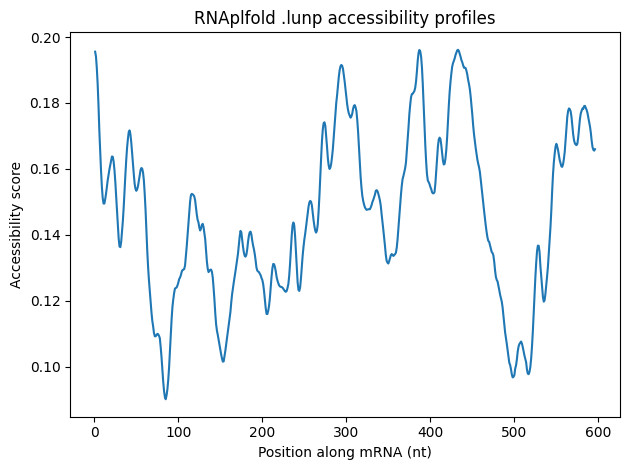

In [76]:
plt.figure()

s = df[f"score"].rolling(30, center=True, min_periods=1).mean()
plt.plot(df["pos"], s)
plt.xlabel("Position along mRNA (nt)")
plt.ylabel("Accessibility score")
plt.title("RNAplfold .lunp accessibility profiles")
plt.tight_layout()
plt.show()


In [24]:
df['pos'].loc[1:7]

1    2
2    3
3    4
4    5
5    6
6    7
7    8
Name: pos, dtype: int64

In [22]:
df.shape[-1]-1

21

In [23]:
k=np.arange(1,df.shape[-1]-1)
df=df[~df['pos'].isin(k)]

In [28]:
df.head()

,pos,u1,u2,u3,u4,u5,u6,u7,u8,u9,...,u12,u13,u14,u15,u16,u17,u18,u19,u20,u21
0,1,0.685346,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.698669,0.566359,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.681892,0.595772,0.483178,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.832515,0.631687,0.555163,0.451184,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.752560,0.690774,0.617421,0.544556,0.442702,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
df['pos']=df['pos']-df.shape[-1]+2

In [26]:
df.head()

,pos,u1,u2,u3,u4,u5,u6,u7,u8,u9,...,u12,u13,u14,u15,u16,u17,u18,u19,u20,u21
20,1,0.092062,0.090491,0.078029,0.073565,0.070819,0.067789,0.063571,0.057930,0.053234,...,0.033642,0.025238,0.016182,0.004507,0.001596,0.001473,0.001378,0.001204,0.001026,0.000846
21,2,0.019740,0.016554,0.016848,0.006650,0.004521,0.004394,0.004337,0.004224,0.002890,...,0.001665,0.001310,0.000989,0.000663,0.000247,0.000132,0.000127,0.000119,0.000107,0.000092
22,3,0.163026,0.018819,0.016189,0.016498,0.006312,0.004194,0.004080,0.004038,0.003943,...,0.001872,0.001475,0.001153,0.000869,0.000584,0.000223,0.000125,0.000119,0.000113,0.000101
23,4,0.067474,0.028197,0.005228,0.003938,0.004069,0.004015,0.001968,0.001997,0.002049,...,0.000564,0.000508,0.000408,0.000282,0.000211,0.000154,0.000089,0.000059,0.000057,0.000054
24,5,0.117075,0.036210,0.017321,0.001012,0.000673,0.000673,0.000696,0.000707,0.000691,...,0.000220,0.000217,0.000186,0.000117,0.000089,0.000046,0.000022,0.000009,0.000004,0.000004


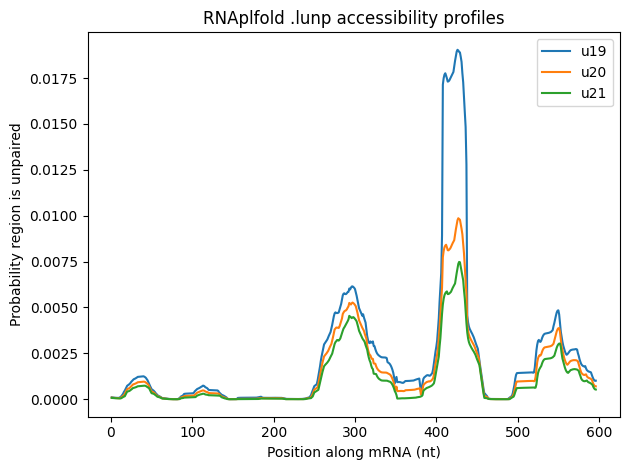

In [27]:
to_show = [19,20,21]
to_show = [k for k in to_show if k <= U]

plt.figure()
for k in to_show:
    # moving-average smoothing for readability (window ~ 41 nt)
    s = df[f"u{k}"].rolling(30, center=True, min_periods=1).mean()
    plt.plot(df["pos"], s, label=f"u{k}")
plt.xlabel("Position along mRNA (nt)")
plt.ylabel("Probability region is unpaired")
plt.title("RNAplfold .lunp accessibility profiles")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

def lunp_to_df(lunp_file, siRNA_length):
    """
    Convert an RNAplfold _lunp file to a pandas DataFrame.
    """
    records = []
    with open(lunp_file) as fh:
        for line in fh:
            parts = line.split()
            if not parts or not parts[0].isdigit():
                continue
            if len(parts) < siRNA_length + 1:
                continue
            pos0 = int(parts[0]) - 1
            values = parts[1:siRNA_length+1]
            # handle "NA" gracefully
            values = [None if v == "NA" else float(v) for v in values]
            records.append([pos0+1] + values)

    cols = ["Position"] + [f"P_unpaired_len{l}" for l in range(1, siRNA_length+1)]
    return pd.DataFrame(records, columns=cols)


# Example usage:
df = lunp_to_df("NM_000371.4_lunp", siRNA_length=23)
print(df.head())


   Position  P_unpaired_len1  P_unpaired_len2  P_unpaired_len3  \
0         1         0.685346              NaN              NaN   
1         2         0.698669         0.566359              NaN   
2         3         0.681892         0.595772         0.483178   
3         4         0.832515         0.631687         0.555163   
4         5         0.752560         0.690774         0.617421   

   P_unpaired_len4  P_unpaired_len5  P_unpaired_len6  P_unpaired_len7  \
0              NaN              NaN              NaN              NaN   
1              NaN              NaN              NaN              NaN   
2              NaN              NaN              NaN              NaN   
3         0.451184              NaN              NaN              NaN   
4         0.544556         0.442702              NaN              NaN   

   P_unpaired_len8  P_unpaired_len9  ...  P_unpaired_len14  P_unpaired_len15  \
0              NaN              NaN  ...               NaN               NaN   
1   

In [3]:
df.head()

,Position,P_unpaired_len1,P_unpaired_len2,P_unpaired_len3,P_unpaired_len4,P_unpaired_len5,P_unpaired_len6,P_unpaired_len7,P_unpaired_len8,P_unpaired_len9,...,P_unpaired_len14,P_unpaired_len15,P_unpaired_len16,P_unpaired_len17,P_unpaired_len18,P_unpaired_len19,P_unpaired_len20,P_unpaired_len21,P_unpaired_len22,P_unpaired_len23
0,1,0.685346,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,0.698669,0.566359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,0.681892,0.595772,0.483178,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,0.832515,0.631687,0.555163,0.451184,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,0.752560,0.690774,0.617421,0.544556,0.442702,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
import numpy as np
a=np.arange(0,10)
a

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [3]:
a=range(0,10)

In [6]:
a[-1]

9